# Try out CNN on averaged EEG data

## Pre-processing
+ Import data.
+ Apply filters (bandpass).
+ Detect potential bad channels and replace them by interpolation.
+ Detect potential bad epochs and remove them.
+ Average over a number of randomly drawn epochs (of same person and same stimuli).

## Train CNN network
+ Define network architecture
+ Split data
+ Train model


## Import packages & links

In [1]:
# Import packages
import os
import sys
import csv
import fnmatch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.insert(0, os.path.dirname(os.getcwd()))

from config import ROOT, PATH_CODE, PATH_DATA, PATH_OUTPUT, PATH_METADATA

import mne
#%matplotlib inline
#from mayavi import mlab

In [3]:
PATH_CNTS = os.path.join(PATH_DATA, "41mnd mmn")
PATH_DATA_processed = os.path.join(PATH_DATA, 'processed_data_41mnd')

## Load pre-processed dataset
+ See notebook for preprocessing: ePODIUM_prepare_data_for_ML.ipynb.ipynb

In [4]:
dirs = os.listdir(PATH_DATA_processed)
files_npy = fnmatch.filter(dirs, "*.npy")
files_csv = fnmatch.filter(dirs, "*.csv")

In [5]:
len(files_csv), len(files_npy)

(256, 256)

### Count the (main) labels for all present files

In [6]:
def read_labels(filename, PATH):
    metadata = []
    filename = os.path.join(PATH, filename)
    with open(filename, 'r') as readFile:
        reader = csv.reader(readFile, delimiter=',')
        for row in reader:
            #if len(row) > 0:
            metadata.append(row)
    readFile.close()
    
    return metadata[0]

In [7]:
label_collection = []
label_counts = []

for filename in files_csv:
    y_EEG = read_labels(filename, PATH_DATA_processed)
    labels_unique = list(set(y_EEG))
    label_collection.append(labels_unique)
    
    # Count instances for each unique label
    label_count = []
    for label in labels_unique:
        idx = np.where(np.array(y_EEG) == label)[0]
        label_count.append(len(idx))
    label_counts.append(label_count)

In [8]:
def transform_label(label,
                   label_dict,
                   main_label_dict = None):
    if label in label_dict:
        label_new = label_dict[label]
    else:
        label_new = None
    
    if main_label_dict is not None:
        if label in main_label_dict:
            main_label = main_label_dict[label]
        else:
            main_label = None
        return label_new, main_label
    
    else:
        return label_new
    

### Define new labels

In [9]:
label_dict  = {
    '3dys0_risk0': '0',
    '13dys0_risk0': '1',
    '66dys0_risk0': '2',
    '3dys0_risk1': '0',
    '13dys0_risk1': '1',
    '66dys0_risk1': '2',
    '3dys1_risk0': '3',
    '13dys1_risk0': '4',
    '66dys1_risk0': '5',
    '3dys1_risk1': '3',
    '13dys1_risk1': '4',
    '66dys1_risk1': '5',
}


main_label_dict  = {
    '3dys0_risk0': '0',
    '13dys0_risk0': '0',
    '66dys0_risk0': '0',
    '3dys0_risk1': '0',
    '13dys0_risk1': '0',
    '66dys0_risk1': '0',
    '3dys1_risk0': '1',
    '13dys1_risk0': '1',
    '66dys1_risk0': '1',
    '3dys1_risk1': '1',
    '13dys1_risk1': '1',
    '66dys1_risk1': '1',
}
"""
main_label_dict  = {
    '3dys0_risk0': '0',
    '13dys0_risk0': '0',
    '66dys0_risk0': '0',
    '3dys0_risk1': '1',
    '13dys0_risk1': '1',
    '66dys0_risk1': '1',
    '3dys1_risk0': '0',
    '13dys1_risk0': '0',
    '66dys1_risk0': '0',
    '3dys1_risk1': '1',
    '13dys1_risk1': '1',
    '66dys1_risk1': '1',
}
"""

"\nmain_label_dict  = {\n    '3dys0_risk0': '0',\n    '13dys0_risk0': '0',\n    '66dys0_risk0': '0',\n    '3dys0_risk1': '1',\n    '13dys0_risk1': '1',\n    '66dys0_risk1': '1',\n    '3dys1_risk0': '0',\n    '13dys1_risk0': '0',\n    '66dys1_risk0': '0',\n    '3dys1_risk1': '1',\n    '13dys1_risk1': '1',\n    '66dys1_risk1': '1',\n}\n"

### Collect main labels (here: dyslexic 0 | 1)

In [10]:
main_labels = [transform_label(x[0], label_dict, main_label_dict)[1] for x in label_collection]
len(main_labels)

256

In [11]:
main_labels.count('0'), main_labels.count('1')

(157, 99)

## Import and initiate data generator function

In [12]:
from dataset_generator import DataGenerator

In [13]:
files_csv[:5]

['processed_data_003_41_jc_mmn36_wk.csv',
 'processed_data_005_41_jc_mmn36_mixed.csv',
 'processed_data_007_41_jc_mmn36_wk.csv',
 'processed_data_008_41_jc_mmn36_wk.csv',
 'processed_data_009_41_jc_mmn36_slp.csv']

### Split data set

In [14]:
for label in list(set(main_labels)):
    print("Found datapoints for label", label, "--->", main_labels.count(label))

Found datapoints for label 0 ---> 157
Found datapoints for label 1 ---> 99


In [16]:
np.random.seed(1098)
split_ratio = (0.7, 0.15, 0.15)

IDs_train = []
IDs_val = []
IDs_test = []

for label in list(set(main_labels)):
    idx = np.where(np.array(main_labels) == label)[0]
    N_label = len(idx)
    print("Found", N_label, "datapoints for label", label)
    
    N_train = int(split_ratio[0] * N_label)
    N_val = int(split_ratio[1] * N_label)
    N_test = N_label - N_train - N_val
    print("Split dataset for label", label, "into train/val/test fractions:", N_train, N_val, N_test)
    
    # Select training, validation, and test IDs:
    trainIDs = np.random.choice(idx, N_train, replace=False)
    valIDs = np.random.choice(list(set(idx) - set(trainIDs)), N_val, replace=False)
    testIDs = list(set(idx) - set(trainIDs) - set(valIDs))
    
    IDs_train.extend(list(trainIDs))
    IDs_val.extend(list(valIDs))
    IDs_test.extend(list(testIDs))

Found 157 datapoints for label 0
Split dataset for label 0 into train/val/test fractions: 109 23 25
Found 99 datapoints for label 1
Split dataset for label 1 into train/val/test fractions: 69 14 16


In [17]:
print(IDs_test)

[133, 139, 19, 22, 25, 156, 37, 40, 45, 184, 66, 72, 92, 94, 234, 109, 111, 115, 116, 245, 248, 121, 250, 123, 125, 96, 33, 162, 97, 104, 169, 170, 47, 239, 148, 252, 183, 56, 153, 60, 157]


In [18]:
print(IDs_train)

[87, 147, 209, 189, 130, 158, 84, 88, 83, 137, 203, 165, 3, 195, 6, 211, 112, 208, 228, 113, 20, 110, 251, 108, 194, 13, 17, 1, 26, 210, 10, 18, 202, 76, 28, 207, 80, 231, 15, 185, 12, 7, 27, 134, 122, 219, 135, 190, 126, 129, 160, 199, 149, 38, 93, 128, 204, 24, 2, 214, 166, 188, 220, 16, 193, 52, 240, 89, 54, 0, 65, 138, 46, 200, 57, 36, 254, 23, 5, 90, 91, 82, 230, 154, 192, 179, 177, 232, 107, 191, 131, 168, 42, 8, 201, 186, 41, 235, 247, 197, 196, 140, 198, 58, 213, 77, 124, 4, 81, 176, 39, 86, 44, 102, 146, 244, 253, 151, 43, 249, 150, 223, 163, 180, 255, 103, 85, 34, 68, 106, 50, 167, 48, 31, 241, 63, 152, 178, 64, 142, 242, 222, 59, 175, 99, 35, 238, 155, 32, 78, 67, 98, 181, 51, 53, 164, 136, 174, 221, 224, 229, 29, 159, 144, 100, 212, 218, 101, 143, 237, 171, 236, 182, 62, 215, 145, 30, 243]


In [19]:
label_dict  = {
    '3dys0_risk0': '0',
    '13dys0_risk0': '0',
    '66dys0_risk0': '0',
    '3dys0_risk1': '1',
    '13dys0_risk1': '1',
    '66dys0_risk1': '1',
    '3dys1_risk0': '0',
    '13dys1_risk0': '0',
    '66dys1_risk0': '0',
    '3dys1_risk1': '1',
    '13dys1_risk1': '1',
    '66dys1_risk1': '1',
}

In [20]:
label_dict  = {
    '3dys0_risk0': '0',
    '13dys0_risk0': '0',
    '66dys0_risk0': '0',
    '3dys0_risk1': '0',
    '13dys0_risk1': '0',
    '66dys0_risk1': '0',
    '3dys1_risk0': '1',
    '13dys1_risk0': '1',
    '66dys1_risk0': '1',
    '3dys1_risk1': '1',
    '13dys1_risk1': '1',
    '66dys1_risk1': '1',
}

binarizer_dict  = {
    '0': [0],
    '1': [1]
}

In [20]:
label_dict  = {
    '3dys0_risk0': '0',
    '13dys0_risk0': '1',
    '66dys0_risk0': '2',
    '3dys0_risk1': '0',
    '13dys0_risk1': '1',
    '66dys0_risk1': '2',
    '3dys1_risk0': '3',
    '13dys1_risk0': '4',
    '66dys1_risk0': '5',
    '3dys1_risk1': '3',
    '13dys1_risk1': '4',
    '66dys1_risk1': '5',
}

binarizer_dict  = {
    '0': [1, 0, 0, 0, 0, 0],
    '1': [0, 1, 0, 0, 0, 0],
    '2': [0, 0, 1, 0, 0, 0],
    '3': [0, 0, 0, 1, 0, 0],
    '4': [0, 0, 0, 0, 1, 0],
    '5': [0, 0, 0, 0, 0, 1]
}

In [44]:
train_generator = DataGenerator(list_IDs = IDs_train,
                                 main_labels = main_labels,
                                 label_dict = label_dict,
                                 binarizer_dict = binarizer_dict,
                                 path_data = PATH_DATA_processed,
                                 filenames = [x[:-4] for x in files_csv],
                                 data_path = PATH_DATA_processed, 
                                 to_fit=True, 
                                 n_average = 40,
                                 batch_size = 32,
                                 iter_per_epoch = 50,
                                 up_sampling = True,
                                 n_timepoints = 501,
                                 n_channels=30, 
                                 n_classes=1, 
                                 shuffle=True)

val_generator = DataGenerator(list_IDs = IDs_val,
                                 main_labels = main_labels,
                                 label_dict = label_dict,
                                 binarizer_dict = binarizer_dict,
                                 path_data = PATH_DATA_processed,
                                 filenames = [x[:-4] for x in files_csv],
                                 data_path = PATH_DATA_processed, 
                                 to_fit=True, 
                                 n_average = 40,
                                 batch_size = 32,
                                 iter_per_epoch = 50,
                                 up_sampling = True,
                                 n_timepoints = 501,
                                 n_channels=30, 
                                 n_classes=1, 
                                 shuffle=True)

In [39]:
X, y  = train_generator.__getitem__(0)

In [40]:
X.shape, len(y)

((113, 501, 30), 113)

In [41]:
print(y[:11])

[[0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]]


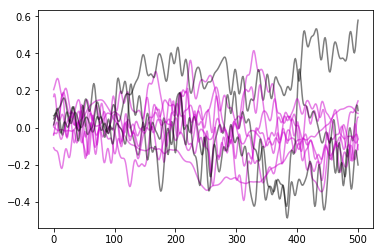

In [33]:
for i in range(10):
    #label = np.where(y[i] == 1)[0][0]
    label = 4*y[i][0]
    plt.plot(X[i,:,2], alpha = 0.5, color=(label/5,0, label/5))

## Define model architecture

In [34]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import optimizers

In [45]:
# Simple CNN model
n_timesteps = 501
n_features = 30
n_outputs = 1 #6

model = tf.keras.Sequential()
model.add(layers.Conv1D(filters=48, kernel_size=20, input_shape=(n_timesteps,n_features)))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU())
model.add(layers.AveragePooling1D(pool_size=2))

model.add(layers.Conv1D(filters=64, kernel_size=10)) #, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU())
model.add(layers.AveragePooling1D(pool_size=2))

model.add(layers.Conv1D(filters=96, kernel_size=5)) #, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU())
model.add(layers.AveragePooling1D(pool_size=2))

#model.add(layers.Conv1D(filters=96, kernel_size=3, activation='relu'))
#model.add(layers.AveragePooling1D(pool_size=2))
#model.add(layers.MaxPooling1D(pool_size=2))

model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(60, activation='relu'))
model.add(layers.Dense(n_outputs, activation='softmax'))

#Adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=True)
#model.compile(loss='categorical_crossentropy', optimizer=Adam, metrics=['accuracy'])
#model.compile(loss='binary_crossentropy', optimizer=Adam, metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])

In [36]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 482, 48)           28848     
_________________________________________________________________
batch_normalization_v1 (Batc (None, 482, 48)           192       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 482, 48)           0         
_________________________________________________________________
average_pooling1d (AveragePo (None, 241, 48)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 232, 64)           30784     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 232, 64)           256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 232, 64)           0         
__________

In [46]:
# Save best model and include early stopping
output_filename = 'CNN_EEG_classifier_avg_41mnd'
output_file = os.path.join(PATH_CODE, 'models_trained' , output_filename + "-{epoch:02d}-{val_acc:.2f}.hdf5")
checkpointer = ModelCheckpoint(filepath = output_file, 
                               monitor='val_acc', 
                               verbose=1, 
                               save_best_only=False)
earlystopper = EarlyStopping(monitor='val_acc', patience=5, verbose=1)

model.fit_generator(generator=train_generator, 
                   validation_data=val_generator,
                   epochs=50,
                   callbacks = [
                       checkpointer, 
                        earlystopper,
                   ]
                  )

Epoch 1/50
1/1 [==============================] - 8s 8s/step - loss: 6.7004 - acc: 0.5797

Epoch 00001: saving model to C:\OneDrive - Netherlands eScience Center\Project_ePodium\EEG_dyslexia_prediction\models_trained\CNN_EEG_classifier_avg_41mnd-01-0.58.hdf5
5/5 [==============================] - 42s 8s/step - loss: 8.2022 - acc: 0.4872 - val_loss: 6.7004 - val_acc: 0.5797
Epoch 2/50
1/1 [==============================] - 8s 8s/step - loss: 7.6344 - acc: 0.5211

Epoch 00002: saving model to C:\OneDrive - Netherlands eScience Center\Project_ePodium\EEG_dyslexia_prediction\models_trained\CNN_EEG_classifier_avg_41mnd-02-0.52.hdf5
5/5 [==============================] - 33s 7s/step - loss: 7.2189 - acc: 0.5471 - val_loss: 7.6344 - val_acc: 0.5211
Epoch 3/50
1/1 [==============================] - 8s 8s/step - loss: 5.7570 - acc: 0.6389

Epoch 00003: saving model to C:\OneDrive - Netherlands eScience Center\Project_ePodium\EEG_dyslexia_prediction\models_trained\CNN_EEG_classifier_avg_41mnd-03

In [81]:
model.get_weights()

[array([[[-0.03874134,  0.02038676,  0.0245813 , ..., -0.01965807,
          -0.04657479,  0.01650143],
         [-0.0291171 , -0.00678881,  0.01854139, ..., -0.02115149,
           0.04429143, -0.04085149],
         [-0.03921856, -0.04953679, -0.02490321, ..., -0.03662722,
          -0.01513935,  0.00743445],
         ...,
         [ 0.01758774, -0.04316538,  0.02759956, ...,  0.03900746,
           0.04800209,  0.00755909],
         [-0.05591447,  0.02475474,  0.05448014, ...,  0.03974395,
          -0.0491508 , -0.00792804],
         [-0.04729754, -0.03251707, -0.0327961 , ..., -0.0245767 ,
          -0.02379675, -0.05093605]],
 
        [[ 0.03765684, -0.03020068,  0.03565044, ..., -0.00223496,
          -0.03925662, -0.05240246],
         [-0.05593536, -0.04719132, -0.05854374, ...,  0.00984705,
          -0.03317313,  0.05707248],
         [-0.00268311, -0.04649076, -0.04206308, ...,  0.00294929,
          -0.00841707,  0.04629105],
         ...,
         [-0.05738391,  0.0429848

In [50]:
from inception_time import InceptionTime

In [72]:
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

class InceptionTime:

    def __init__(self, 
                 output_directory, 
                 input_shape, 
                 nb_classes, 
                 verbose=False, 
                 build=True, 
                 batch_size=64,
                 nb_filters=32, 
                 use_residual=True, 
                 use_bottleneck=True, 
                 depth=6, 
                 kernel_size=41, 
                 nb_epochs=1500):
        """
        
        """

        self.output_directory = output_directory
        self.input_shape = input_shape
        self.nb_classes = nb_classes
        self.nb_filters = nb_filters
        self.use_residual = use_residual
        self.use_bottleneck = use_bottleneck
        self.depth = depth
        self.kernel_size = kernel_size - 1
        self.callbacks = None
        self.batch_size = batch_size
        self.bottleneck_size = 32
        self.nb_epochs = nb_epochs

        if build == True:
            self.model = self.build_model()
            if (verbose == True):
                self.model.summary()
            self.verbose = verbose
            self.model.save_weights(self.output_directory + 'model_init.hdf5')


    def _inception_module(self, input_tensor, stride=1, activation='linear'):

        if self.use_bottleneck and int(input_tensor.shape[-1]) > 1:
            input_inception = layers.Conv1D(filters=self.bottleneck_size, kernel_size=1,
                                                  padding='same', activation=activation, use_bias=False)(input_tensor)
        else:
            input_inception = input_tensor

        # kernel_size_s = [3, 5, 8, 11, 17]
        kernel_size_s = [self.kernel_size // (2 ** i) for i in range(3)]

        conv_list = []

        for i in range(len(kernel_size_s)):
            conv_list.append(layers.Conv1D(filters=self.nb_filters, kernel_size=kernel_size_s[i],
                                                 strides=stride, padding='same', activation=activation, use_bias=False)(
                input_inception))

        max_pool_1 = layers.MaxPool1D(pool_size=3, strides=stride, padding='same')(input_tensor)

        conv_6 = layers.Conv1D(filters=self.nb_filters, kernel_size=1,
                                     padding='same', activation=activation, use_bias=False)(max_pool_1)

        conv_list.append(conv_6)

        x = layers.Concatenate(axis=2)(conv_list)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(activation='relu')(x)
        return x

    def _shortcut_layer(self, input_tensor, out_tensor):
        shortcut_y = layers.Conv1D(filters=int(out_tensor.shape[-1]), kernel_size=1,
                                         padding='same', use_bias=False)(input_tensor)
        shortcut_y = layers.BatchNormalization()(shortcut_y)

        x = layers.Add()([shortcut_y, out_tensor])
        x = layers.Activation('relu')(x)
        return x

    def build_model(self):
        input_layer = layers.Input(self.input_shape)

        x = input_layer
        input_res = input_layer

        for d in range(self.depth):

            x = self._inception_module(x)

            if self.use_residual and d % 3 == 2:
                x = self._shortcut_layer(input_res, x)
                input_res = x

        gap_layer = layers.GlobalAveragePooling1D()(x)
        
        if self.nb_classes == 2:
            output_layer = layers.Dense(1, activation='softmax')(gap_layer)
        else:
            output_layer = layers.Dense(self.nb_classes, activation='softmax')(gap_layer)

        model = Model(inputs=input_layer, outputs=output_layer)

        if self.nb_classes == 2:
            model.compile(loss='binary_crossentropy', 
                          optimizer=optimizers.Adam(),
                          metrics=['accuracy'])
        else:
            model.compile(loss='categorical_crossentropy', 
                          optimizer=optimizers.Adam(),
                          metrics=['accuracy'])

        reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50,
                                                      min_lr=0.0001)

        file_path = self.output_directory + 'best_model.hdf5'

        model_checkpoint = ModelCheckpoint(filepath=file_path, monitor='loss',
                                                           save_best_only=True)

        self.callbacks = [reduce_lr, model_checkpoint]

        return model

In [73]:
inception_model = InceptionTime(output_directory = os.path.join(PATH_CODE, 'models_trained'), 
                                 input_shape = (501,30), 
                                 nb_classes = 2, 
                                 verbose=False, 
                                 build=True, 
                                 batch_size=64,
                                 nb_filters=32, 
                                 use_residual=True, 
                                 use_bottleneck=True, 
                                 depth=6, 
                                 kernel_size=41, 
                                 nb_epochs=1500)

In [74]:
model_inception = inception_model.build_model() 
model_inception.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 501, 30)      0                                            
__________________________________________________________________________________________________
conv1d_282 (Conv1D)             (None, 501, 32)      960         input_11[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_51 (MaxPooling1D) (None, 501, 30)      0           input_11[0][0]                   
__________________________________________________________________________________________________
conv1d_283 (Conv1D)             (None, 501, 32)      40960       conv1d_282[0][0]                 
__________________________________________________________________________________________________
conv1d_284

In [75]:
# Save best model and include early stopping
output_filename = 'InceptionTime_classifier_avg_41mnd'
output_file = os.path.join(PATH_CODE, 'models_trained' , output_filename + "-{epoch:02d}-{val_acc:.2f}.hdf5")
checkpointer = ModelCheckpoint(filepath = output_file, 
                               monitor='val_acc', 
                               verbose=1, 
                               save_best_only=False)
earlystopper = EarlyStopping(monitor='val_acc', patience=5, verbose=1)

model_inception.fit_generator(generator=train_generator, 
                           validation_data=val_generator,
                           epochs=50,
                           callbacks = [
                                        checkpointer, 
                                        earlystopper,
                   ]
                  )

Epoch 1/50
1/1 [==============================] - 15s 15s/step - loss: 9.3779 - acc: 0.4118

Epoch 00001: saving model to C:\OneDrive - Netherlands eScience Center\Project_ePodium\EEG_dyslexia_prediction\models_trained\InceptionTime_classifier_avg_41mnd-01-0.41.hdf5
5/5 [==============================] - 113s 23s/step - loss: 8.5369 - acc: 0.4649 - val_loss: 9.3779 - val_acc: 0.4118
Epoch 2/50
1/1 [==============================] - 13s 13s/step - loss: 6.3770 - acc: 0.6000

Epoch 00002: saving model to C:\OneDrive - Netherlands eScience Center\Project_ePodium\EEG_dyslexia_prediction\models_trained\InceptionTime_classifier_avg_41mnd-02-0.60.hdf5
5/5 [==============================] - 60s 12s/step - loss: 7.1511 - acc: 0.5514 - val_loss: 6.3770 - val_acc: 0.6000
Epoch 3/50
1/1 [==============================] - 13s 13s/step - loss: 10.0209 - acc: 0.3714

Epoch 00003: saving model to C:\OneDrive - Netherlands eScience Center\Project_ePodium\EEG_dyslexia_prediction\models_trained\Inception

# 1. Make clearer disctinction between training, test, validation data!
To be sure the network is able to make predictions using unseen data, the dataset could be split according to persons! Unfortunately we only have data here for 57 persons (24 in group 1 and 33 in group 2).  
This makes this approach a bit complicated

## Idea for next steps:
We could also loop through different test-person/train-person splits and independently train models on those datasets. Then, in the the end the outcome would be averaged over all of those. This way we would make better use of the data we have!

In [11]:
groups = []
for ID in range(len(metadata)):
    if ID == 0:
        low = 0
    else:
        low = int(metadata[ID-1][2])
        
    groups.append(int(label_collection[low]/3))

In [12]:
group_1_ids = np.where(np.array(groups) == 1)[0]
group_2_ids = np.where(np.array(groups) == 1)[0]

In [13]:
# inspect group 2 ID's
group_2_ids

array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43], dtype=int64)

In [15]:
n_epochs = 30 # Average over n_epochs epochs
n_class3_per_patient = 20
n_class13_per_patient = 10
n_class66_per_patient = 10

# Make selection 
group_1_ids = np.where(np.array(groups) == 1)[0]
group_2_ids = np.where(np.array(groups) == 2)[0]
keep_group1_for_test = 10
keep_group2_for_test = 10

# Initialize random numbers to get reproducible results 
np.random.seed(1)

# Make random selection
selected_ids_test = [x for x in np.concatenate([np.random.choice(group_1_ids, keep_group1_for_test),
                                   np.random.choice(group_2_ids, keep_group2_for_test)])]

selected_ids = [x for x in range(len(metadata)) if not x in selected_ids_test]

In [111]:
selected_ids_test

[6, 31, 32, 9, 10, 31, 6, 35, 0, 36, 12, 23, 18, 17, 49, 44, 29, 44, 22, 52]

In [12]:
X_data, y_data = create_averaged_data(signal_collection, 
                         label_collection, 
                         metadata, 
                         n_epochs, 
                         selected_ids)

NameError: name 'create_averaged_data' is not defined

In [18]:
X_test, y_test = create_averaged_data(signal_collection, 
                         label_collection, 
                         metadata, 
                         n_epochs, 
                         selected_ids_test)

person ID: 6 . Originally from file:  308_17_jc_mmn36_wk.cnt
person ID: 31 . Originally from file:  602-115-17m-mc-mmn.cnt
person ID: 32 . Originally from file:  604-133-17m-jc-mmn36.cnt
person ID: 9 . Originally from file:  337_17_jc_mmn36_wk.cnt
person ID: 10 . Originally from file:  343_17_mc_mmm36_wk.cnt
person ID: 31 . Originally from file:  602-115-17m-mc-mmn.cnt
person ID: 6 . Originally from file:  308_17_jc_mmn36_wk.cnt
person ID: 35 . Originally from file:  611_157_17m_mc_mmn36.cnt
person ID: 0 . Originally from file:  034_17_mc_mmn36_wk.cnt
person ID: 36 . Originally from file:  619-247-17m-mc-mmn36.cnt
person ID: 12 . Originally from file:  406_17_md_mmn.cnt
person ID: 23 . Originally from file:  472_17_jd_mmn36_wk.cnt
person ID: 18 . Originally from file:  436_17_jd_mmn36_wk.cnt
person ID: 17 . Originally from file:  435_17_md_mmn36_wk.cnt
person ID: 49 . Originally from file:  726_126_17m-jr_mmn36.cnt
person ID: 44 . Originally from file:  707-060-17m-jd-mmn.cnt
person ID

In [19]:
print(X_data.shape, len(y_data))
print(X_test.shape, len(y_test))

(1570, 30, 501) 1570
(800, 30, 501) 800


In [32]:
# Check if samples of all label classes are present in both test and train
for i in [3, 6, 13, 26, 66, 132]:
    print(i, np.sum(np.array(y_test) == i))

3 200
6 200
13 100
26 100
66 100
132 100


## Normalization of EEG signals

In [33]:
Xmean = np.concatenate([X_data, X_test]).mean()
X_data = X_data - Xmean
X_test = X_test - Xmean

Xmax = np.concatenate([X_data, X_test]).max()

X_data = X_data / Xmax
X_test = X_test / Xmax

In [34]:
X_data.mean(), X_data.max(),X_data.min()

(-0.0001577112562104391, 1.0, -0.8624177914571192)

## Split training data
### Now the test dataset is already entirely seperate from the rest! 
+ validation data, used to monitor the model progress and avoid overfitting.
+ testing data, meant for final check on model performance.
+ --> Create validation and test data set from seperated data!!

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=1)
X_train, y_train = shuffle(X_data, y_data, random_state=1)

In [36]:
print('Train set size:', X_train.shape[0])
print('Validation set size:', X_val.shape[0])
print('Test set size:', X_test.shape[0])
print()
print("X_train mean, min, max: ", np.mean(X_train), np.min(X_train), np.max(X_train))

Train set size: 1570
Validation set size: 400
Test set size: 400

X_train mean, min, max:  -0.00015771125621043887 -0.8624177914571192 1.0


In [61]:
# Check if samples of all label classes are present in both test and train
for i in [3, 6, 13, 26, 66, 132]:
    print(i, np.sum(np.array(y_test) == i))

print()
for i in [3, 6, 13, 26, 66, 132]:
    print(i, np.sum(np.array(y_val) == i))

3 98
6 101
13 52
26 49
66 48
132 52

3 102
6 99
13 48
26 51
66 52
132 48


## Switch to 1-hot encoding for labels
We have six categories or classes. Those are best represented by a so called **1-hot encoding**. This means nothing else than simply a binary 0-or-1 for every class.  
The categories we have are:  
3 -> group 0 + stimuli "3"  
6 -> group 1 + stimuli "3"  
13 -> group 0 + stimuli "13"  
26 -> group 1 + stimuli "13"  
66 -> group 0 + stimuli "66"  
128 -> group 1 + stimuli "66"  


In [37]:
from sklearn.preprocessing import LabelBinarizer
label_transform = LabelBinarizer()

y_train_binary = label_transform.fit_transform(np.array(y_train).astype(int))
y_val_binary = label_transform.fit_transform(np.array(y_val).astype(int))
y_test_binary = label_transform.fit_transform(np.array(y_test).astype(int))

In [38]:
y_val_binary[:10,:]

array([[1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0]])

In [39]:
# Show found labels:
label_transform.classes_

array([  3,   6,  13,  26,  66, 132])

Check distribution accross the 6 label categories:

In [40]:
labels = list(label_transform.classes_)
frequencies = y_train_binary.mean(axis=0)
frequencies_df = pd.DataFrame(frequencies, index=labels, columns=['frequency'])
frequencies_df

,frequency
3,0.203822
6,0.305732
13,0.095541
26,0.152866
66,0.095541
132,0.146497


In [62]:
labels = list(label_transform.classes_)
frequencies = y_test_binary.mean(axis=0)
frequencies_df = pd.DataFrame(frequencies, index=labels, columns=['frequency'])
frequencies_df

,frequency
3,0.2450
6,0.2525
13,0.1300
26,0.1225
66,0.1200
132,0.1300


### Note:
We have more data on group 2 than on group 1. And far more data for stimuli 3 than for stimuli 13 and 66 (not surprising). 

--> post on balancing datasets: https://towardsdatascience.com/handling-imbalanced-datasets-in-deep-learning-f48407a0e758

### Needs some thinking on how to balance the data set !
e.g. by frequency dependend selection rule, or by defining a suitied special loss function....

In [41]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced'
                                               ,np.unique(y_train)
                                               ,y_train)

In [42]:
class_weight

array([0.81770833, 0.54513889, 1.74444444, 1.09027778, 1.74444444,
       1.13768116])

In [43]:
class_weight = {0: class_weight[0],
               1: class_weight[1],
               2: class_weight[2],
               3: class_weight[3],
               4: class_weight[4],
               5: class_weight[5]}

## Define model architecture

In [44]:
import tensorflow as tf
from tensorflow.keras import layers

In [45]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
output_file = 'CNN_EEG_classifier_avg_02'

checkpointer = ModelCheckpoint(filepath = PATH_MODELS + output_file + ".hdf5", monitor='val_acc', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_acc', patience=5, verbose=1)

In [46]:
# Simple CNN model
n_timesteps = 501
n_features = 30
n_outputs = 6

model = tf.keras.Sequential()
#model.add(layers.Conv1D(filters=32, kernel_size=20, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(layers.Conv1D(filters=32, kernel_size=20, input_shape=(n_timesteps,n_features)))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU())
model.add(layers.AveragePooling1D(pool_size=2))

model.add(layers.Conv1D(filters=64, kernel_size=10)) #, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU())
model.add(layers.AveragePooling1D(pool_size=2))

model.add(layers.Conv1D(filters=64, kernel_size=5)) #, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU())
model.add(layers.AveragePooling1D(pool_size=2))

#model.add(layers.Conv1D(filters=96, kernel_size=3, activation='relu'))
#model.add(layers.AveragePooling1D(pool_size=2))
#model.add(layers.MaxPooling1D(pool_size=2))

model.add(layers.Flatten())
model.add(layers.Dense(80, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(n_outputs, activation='softmax'))
#model.compile(loss='categorical_crossentropy', optimizer='adagrad', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [47]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 482, 32)           19232     
_________________________________________________________________
batch_normalization_v1 (Batc (None, 482, 32)           128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 482, 32)           0         
_________________________________________________________________
average_pooling1d (AveragePo (None, 241, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 232, 64)           20544     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 232, 64)           256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 232, 64)           0         
__________

In [48]:
epochs = 50
batch_size = 32

# fit network
model.fit(np.swapaxes(X_train,1,2), 
          y_train_binary, 
          validation_data=(np.swapaxes(X_val,1,2), y_val_binary), 
          epochs=epochs, 
          batch_size=batch_size,
          class_weight = class_weight,
          callbacks = [checkpointer, earlystopper])

Train on 1570 samples, validate on 400 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
1568/1570 [============================>.] - ETA: 0s - loss: 1.7407 - acc: 0.3151
Epoch 00001: val_acc improved from -inf to 0.20000, saving model to C:\OneDrive - Netherlands eScience Center\Project_ePodium\trained_models\CNN_EEG_classifier_avg_02.hdf5
1570/1570 [==============================] - 8s 5ms/sample - loss: 1.7404 - acc: 0.3146 - val_loss: 1.7505 - val_acc: 0.2000
Epoch 2/50
1568/1570 [============================>.] - ETA: 0s - loss: 1.3919 - acc: 0.4062
Epoch 00002: val_acc did not improve from 0.20000
1570/1570 [==============================] - 7s 4ms/sample - loss: 1.3920 - acc: 0.4064 - val_loss: 1.7163 - val_acc: 0.2000
Epoch 3/50
1568/1570 [============================>.] - ETA: 0s - loss: 1.2415 - acc: 0.4541
Epoch 00003: val_acc improved from 0.20000 to 0.34500, saving model to C:\OneDrive - Netherlands eScience Center\Project_ePodium\trained_models\CNN_EEG_cl

## Seems to overfit on the training data and not be able to predict well the validation data

In [49]:
# Evaluate the model
_, train_acc = model.evaluate(np.swapaxes(X_train,1,2), y_train_binary, verbose=0)
_, test_acc = model.evaluate(np.swapaxes(X_test,1,2), y_test_binary, verbose=0)

In [50]:
print("Accuracy on train dataset:", train_acc)
print("Accuracy on test dataset:", test_acc)

Accuracy on train dataset: 0.75605094
Accuracy on test dataset: 0.35


In [51]:
Xtest = np.swapaxes(X_test,1,2)

# Check model predictions:
y_pred_proba = model.predict_proba(Xtest)
y_pred_classes = model.predict_classes(Xtest)

In [67]:
y_test_05 = np.array(y_test.copy())
y_test_05[y_test_05 == 3] = 0
y_test_05[y_test_05 == 6] = 1
y_test_05[y_test_05 == 13] = 2
y_test_05[y_test_05 == 26] = 3
y_test_05[y_test_05 == 66] = 4
y_test_05[y_test_05 == 132] = 5

print(y_test_05[:30].astype(int))
print(y_pred_classes[:30])

[0 5 0 1 0 1 3 5 0 1 0 4 0 2 3 1 5 1 2 0 2 1 2 0 3 0 3 2 3 4]
[0 2 0 1 0 1 2 3 1 0 0 4 0 0 5 1 2 0 3 0 5 0 0 0 5 1 3 3 2 2]


In [68]:
# Calculate accuracy
from sklearn import metrics
print(metrics.accuracy_score(y_test_05, y_pred_classes))

0.35


## Check if groups are predicted correctly:

In [54]:
y_test_12 = np.array(y_test.copy())
y_test_12[y_test_12 == 132] = 2
y_test_12[y_test_12 == 66] = 1
y_test_12[y_test_12 == 26] = 2
y_test_12[y_test_12 == 13] = 1
y_test_12[y_test_12 == 6] = 2
y_test_12[y_test_12 == 3] = 1

y_pred_12 = y_pred_classes.copy()
y_pred_12[(y_pred_12 == 4) | (y_pred_12 == 2) | (y_pred_12 == 0)] = 6
y_pred_12[(y_pred_12 == 5) | (y_pred_12 == 3) | (y_pred_12 == 1)] = 2
y_pred_12[y_pred_12 == 6] = 1

print(y_test_12[:30].astype(int))
print(y_pred_12[:30])

[1 2 1 2 1 2 2 2 1 2 1 1 1 1 2 2 2 2 1 1 1 2 1 1 2 1 2 1 2 1]
[1 2 1 2 1 2 2 2 2 1 1 2 1 1 2 2 2 1 2 1 2 1 1 1 2 2 2 2 2 2]


In [55]:
np.sum(y_test_12 == y_pred_12)/ y_pred_12.shape[0]

0.4925

## Observation:
So far this is not working as a proper discriminator between group1 and group2!  
The test dataset contains about equal amounts of data from both groups, and the model does do better than random guessing (50% hits).

In [69]:
# Confusion matrix:
M_confusion = metrics.confusion_matrix(y_test_05, y_pred_classes)
M_confusion

array([[57, 39,  0,  1,  1,  0],
       [57, 33,  2,  1,  3,  5],
       [ 5,  1,  6, 20, 12,  8],
       [ 8,  4, 12, 12,  3, 10],
       [ 1,  0, 13,  4,  7, 23],
       [ 3,  0, 12,  5,  7, 25]], dtype=int64)

In [80]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    from sklearn.utils.multiclass import unique_labels
    
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    ## Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Normalized confusion matrix
[[0.58163265 0.39795918 0.         0.01020408 0.01020408 0.        ]
 [0.56435644 0.32673267 0.01980198 0.00990099 0.02970297 0.04950495]
 [0.09615385 0.01923077 0.11538462 0.38461538 0.23076923 0.15384615]
 [0.16326531 0.08163265 0.24489796 0.24489796 0.06122449 0.20408163]
 [0.02083333 0.         0.27083333 0.08333333 0.14583333 0.47916667]
 [0.05769231 0.         0.23076923 0.09615385 0.13461538 0.48076923]]


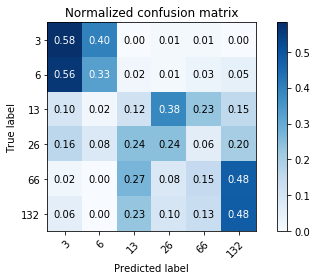

In [84]:
# Plot normalized confusion matrix
labels = list(label_transform.classes_)

plot_confusion_matrix(y_test_05, y_pred_classes, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

plt.savefig('confusion_matrix.pdf')

### Interestingly, it might be that the model at least does see a difference between the types of stimuli!

In [71]:
y_test_bak_dak = np.array(y_test.copy())
y_test_bak_dak[y_test_bak_dak == 132] = 2
y_test_bak_dak[y_test_bak_dak == 66] = 2
y_test_bak_dak[y_test_bak_dak == 26] = 2
y_test_bak_dak[y_test_bak_dak == 13] = 2
y_test_bak_dak[y_test_bak_dak == 6] = 1
y_test_bak_dak[y_test_bak_dak == 3] = 1

y_pred_bak_dak = y_pred_classes.copy()
y_pred_bak_dak[y_pred_bak_dak == 2] = 2
y_pred_bak_dak[y_pred_bak_dak == 5] = 2
y_pred_bak_dak[y_pred_bak_dak == 4] = 2
y_pred_bak_dak[y_pred_bak_dak == 3] = 2
y_pred_bak_dak[y_pred_bak_dak == 1] = 1
y_pred_bak_dak[y_pred_bak_dak == 0] = 1

print(y_test_bak_dak[:30].astype(int))
print(y_pred_bak_dak[:30])

[1 2 1 1 1 1 2 2 1 1 1 2 1 2 2 1 2 1 2 1 2 1 2 1 2 1 2 2 2 2]
[1 2 1 1 1 1 2 2 1 1 1 2 1 1 2 1 2 1 2 1 2 1 1 1 2 1 2 2 2 2]


In [72]:
np.sum(y_test_bak_dak == y_pred_bak_dak)/ y_pred_bak_dak.shape[0]

0.9125

## Interestingly though,...
That would mean that the model is correct in >95% of all cases in distinguishing 'bak' from 'dak'.  
--> **Careful: Needs to be checked if my assumptions about the stimuli are correct...**

# 2. Alternative model architecture
+ Compression in time axis only after 3 convolutional steps
+ Contains batchNormalization layers

In [85]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
output_file = 'CNN_EEG_classifier_avg_03'

checkpointer = ModelCheckpoint(filepath = PATH_MODELS + output_file + ".hdf5", monitor='val_acc', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_acc', patience=5, verbose=1)

In [86]:
# Simple CNN model
n_timesteps = 501
n_features = 30
n_outputs = 6

model = tf.keras.Sequential()
#model.add(layers.Conv1D(filters=32, kernel_size=20, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(layers.Conv1D(filters=32, kernel_size=20, input_shape=(n_timesteps,n_features)))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU())

model.add(layers.Conv1D(filters=64, kernel_size=10)) #, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU())

model.add(layers.Conv1D(filters=32, kernel_size=5)) #, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU())
model.add(layers.AveragePooling1D(pool_size=4))

model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adagrad', metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [87]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 482, 32)           19232     
_________________________________________________________________
batch_normalization_v1_3 (Ba (None, 482, 32)           128       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 482, 32)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 473, 64)           20544     
_________________________________________________________________
batch_normalization_v1_4 (Ba (None, 473, 64)           256       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 473, 64)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 469, 32)           10272     
__________

In [88]:
epochs = 50
batch_size = 32

# fit network
model.fit(np.swapaxes(X_train,1,2), 
          y_train_binary, 
          validation_data=(np.swapaxes(X_val,1,2), y_val_binary), 
          epochs=epochs, 
          batch_size=batch_size,
          class_weight = class_weight,
          callbacks = [checkpointer, earlystopper])

Train on 1570 samples, validate on 400 samples
Epoch 1/50
1568/1570 [============================>.] - ETA: 0s - loss: 2.4284 - acc: 0.2526
Epoch 00001: val_acc improved from -inf to 0.28000, saving model to C:\OneDrive - Netherlands eScience Center\Project_ePodium\trained_models\CNN_EEG_classifier_avg_03.hdf5
1570/1570 [==============================] - 11s 7ms/sample - loss: 2.4266 - acc: 0.2529 - val_loss: 1.6462 - val_acc: 0.2800
Epoch 2/50
1568/1570 [============================>.] - ETA: 0s - loss: 1.5319 - acc: 0.3571
Epoch 00002: val_acc improved from 0.28000 to 0.31500, saving model to C:\OneDrive - Netherlands eScience Center\Project_ePodium\trained_models\CNN_EEG_classifier_avg_03.hdf5
1570/1570 [==============================] - 9s 6ms/sample - loss: 1.5322 - acc: 0.3573 - val_loss: 1.6122 - val_acc: 0.3150
Epoch 3/50
1568/1570 [============================>.] - ETA: 0s - loss: 1.3472 - acc: 0.4037- ETA: 2s - loss: 1.362
Epoch 00003: val_acc did not improve from 0.31500
157

## Seems to overfit on the training data and not be able to predict well the validation data

In [89]:
# Evaluate the model
_, train_acc = model.evaluate(np.swapaxes(X_train,1,2), y_train_binary, verbose=0)
_, test_acc = model.evaluate(np.swapaxes(X_test,1,2), y_test_binary, verbose=0)

In [90]:
print("Accuracy on train dataset:", train_acc)
print("Accuracy on test dataset:", test_acc)

Accuracy on train dataset: 0.61910826
Accuracy on test dataset: 0.365


In [91]:
Xtest = np.swapaxes(X_test,1,2)

# Check model predictions:
y_pred_proba = model.predict_proba(Xtest)
y_pred_classes = model.predict_classes(Xtest)

In [93]:
y_test_05 = np.array(y_test.copy())
y_test_05[y_test_05 == 3] = 0
y_test_05[y_test_05 == 6] = 1
y_test_05[y_test_05 == 13] = 2
y_test_05[y_test_05 == 26] = 3
y_test_05[y_test_05 == 66] = 4
y_test_05[y_test_05 == 132] = 5

print(y_test_05[:20].astype(int))
print(y_pred_classes[:20])

[0 5 0 1 0 1 3 5 0 1 0 4 0 2 3 1 5 1 2 0]
[1 2 2 2 1 1 2 2 0 0 0 1 1 2 5 0 2 0 3 0]


In [94]:
# Calculate accuracy
from sklearn import metrics
print(metrics.accuracy_score(y_test_05, y_pred_classes))

0.365


## Check if groups are predicted correctly:

In [98]:
y_test_12 = np.array(y_test.copy())
y_test_12[y_test_12 == 132] = 2
y_test_12[y_test_12 == 66] = 1
y_test_12[y_test_12 == 26] = 2
y_test_12[y_test_12 == 13] = 1
y_test_12[y_test_12 == 6] = 2
y_test_12[y_test_12 == 3] = 1

y_pred_12 = y_pred_classes.copy()
y_pred_12[(y_pred_12 == 4) | (y_pred_12 == 2) | (y_pred_12 == 0)] = 6
y_pred_12[(y_pred_12 == 5) | (y_pred_12 == 3) | (y_pred_12 == 1)] = 2
y_pred_12[y_pred_12 == 6] = 1

print(y_test_12[:30].astype(int))
print(y_pred_12[:30])

[1 2 1 2 1 2 2 2 1 2 1 1 1 1 2 2 2 2 1 1 1 2 1 1 2 1 2 1 2 1]
[2 1 1 1 2 2 1 1 1 1 1 2 2 1 2 1 1 1 2 1 1 1 2 1 1 2 1 2 1 1]


In [99]:
np.sum(y_test_12 == y_pred_12)/ y_pred_12.shape[0]

0.4875

Normalized confusion matrix
[[0.58080808 0.41919192]
 [0.6039604  0.3960396 ]]


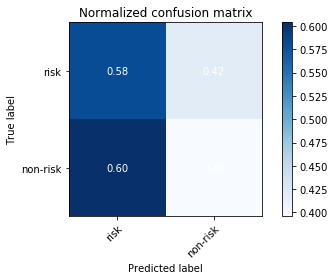

In [109]:
# Plot normalized confusion matrix
labels = list(label_transform.classes_)

plot_confusion_matrix(y_test_12, y_pred_12, classes=['risk', 'non-risk'], normalize=True,
                      title='Normalized confusion matrix')

plt.savefig('confusion_matrix12.pdf')

## Note:
Groups are not correctly predicted. It's not better than trowing dices...

## Check if stimuli types are predicted correctly:

In [102]:
y_test_123 = np.array(y_test.copy())
y_test_123[y_test_123 == 6] = 1
y_test_123[y_test_123 == 3] = 1
y_test_123[y_test_123 == 26] = 2
y_test_123[y_test_123 == 13] = 2
y_test_123[y_test_123 == 132] = 3
y_test_123[y_test_123 == 66] = 3

y_pred_123 = y_pred_classes.copy()
y_pred_123[(y_pred_123 == 1) | (y_pred_123 == 0)] = 1
y_pred_123[(y_pred_123 == 3) | (y_pred_123 == 2)] = 2
y_pred_123[(y_pred_123 == 5) | (y_pred_123 == 4)] = 3

print(y_test_123[:30].astype(int))
print(y_pred_123[:30])

[1 3 1 1 1 1 2 3 1 1 1 3 1 2 2 1 3 1 2 1 2 1 2 1 2 1 2 2 2 3]
[1 2 2 2 1 1 2 2 1 1 1 1 1 2 3 1 2 1 2 1 3 1 2 1 3 1 2 2 3 2]


In [103]:
np.sum(y_test_123 == y_pred_123)/ y_pred_123.shape[0]

0.7475

Normalized confusion matrix
[[0.90954774 0.07035176 0.0201005 ]
 [0.05940594 0.68316832 0.25742574]
 [0.13       0.38       0.49      ]]


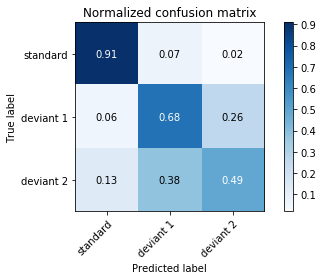

In [110]:
# Plot normalized confusion matrix
labels = list(label_transform.classes_)

plot_confusion_matrix(y_test_123, y_pred_123, classes=['standard', 'deviant 1', 'deviant 2'], normalize=True,
                      title='Normalized confusion matrix')

plt.savefig('confusion_matrix123.pdf')

## Observation:
So far this is not working as a proper discriminator between group1 and group2!  
The test dataset contains about equal amounts of data from both groups, and the model does do better than random guessing (50% hits).

In [100]:
# Confusion matrix:
M_confusion = metrics.confusion_matrix(y_test_05, y_pred_classes)
M_confusion

array([[47, 45,  2,  3,  1,  0],
       [44, 45,  5,  4,  3,  0],
       [ 0,  0, 25, 13, 14,  0],
       [ 3,  3, 20, 11,  8,  4],
       [ 0,  3, 11,  7, 15, 12],
       [ 3,  7, 17,  3, 19,  3]], dtype=int64)

Normalized confusion matrix
[[0.47959184 0.45918367 0.02040816 0.03061224 0.01020408 0.        ]
 [0.43564356 0.44554455 0.04950495 0.03960396 0.02970297 0.        ]
 [0.         0.         0.48076923 0.25       0.26923077 0.        ]
 [0.06122449 0.06122449 0.40816327 0.2244898  0.16326531 0.08163265]
 [0.         0.0625     0.22916667 0.14583333 0.3125     0.25      ]
 [0.05769231 0.13461538 0.32692308 0.05769231 0.36538462 0.05769231]]


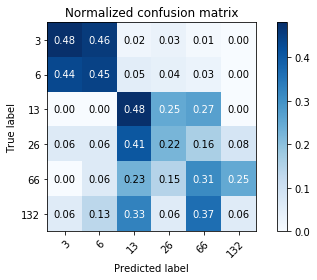

In [101]:
# Plot normalized confusion matrix
labels = list(label_transform.classes_)

plot_confusion_matrix(y_test_05, y_pred_classes, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

plt.savefig('confusion_matrix2.pdf')

# 3. Train on only stimuli labels (not including patient groups)

In [143]:
old_label = [3,6,13,26,66,132]
new_label = [3,3,13,13,66,66]

y_train_123 = np.zeros((len(y_train)))
for i, old in enumerate(old_label):
    y_train_123[np.where(np.array(y_train) == old)[0]] = new_label[i]

y_val_123 = np.zeros((len(y_val)))
for i, old in enumerate(old_label):
    y_val_123[np.where(np.array(y_val) == old)[0]] = new_label[i]
    
y_test_123 = np.zeros((len(y_test)))
for i, old in enumerate(old_label):
    y_test_123[np.where(np.array(y_test) == old)[0]] = new_label[i]

In [144]:
label_transform = LabelBinarizer()

y_train123_binary = label_transform.fit_transform(np.array(y_train_123).astype(int))
y_val123_binary = label_transform.fit_transform(np.array(y_val_123).astype(int))
y_test123_binary = label_transform.fit_transform(np.array(y_test_123).astype(int))

In [117]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
output_file = 'CNN_EEG_classifier_avg_123'

checkpointer = ModelCheckpoint(filepath = PATH_MODELS + output_file + ".hdf5", monitor='val_acc', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_acc', patience=5, verbose=1)

In [118]:
# Simple CNN model
n_timesteps = 501
n_features = 30
n_outputs = 3

model = tf.keras.Sequential()
model.add(layers.Conv1D(filters=32, kernel_size=20, input_shape=(n_timesteps,n_features)))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU())

model.add(layers.Conv1D(filters=64, kernel_size=10)) #, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU())

model.add(layers.Conv1D(filters=32, kernel_size=5)) #, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU())
model.add(layers.AveragePooling1D(pool_size=4))

model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

In [119]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 482, 32)           19232     
_________________________________________________________________
batch_normalization_v1_6 (Ba (None, 482, 32)           128       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 482, 32)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 473, 64)           20544     
_________________________________________________________________
batch_normalization_v1_7 (Ba (None, 473, 64)           256       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 473, 64)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 469, 32)           10272     
__________

In [146]:
y_train123_binary[:10,:]

array([[0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

In [135]:
epochs = 50
batch_size = 32

# Fit network
model.fit(np.swapaxes(X_train,1,2), 
          y_train123_binary, 
          validation_data=(np.swapaxes(X_val,1,2), y_val123_binary), 
          epochs=epochs, 
          batch_size=batch_size,
          class_weight = class_weight,
          callbacks = [checkpointer, earlystopper])

Train on 1570 samples, validate on 400 samples
Epoch 1/50
1568/1570 [============================>.] - ETA: 0s - loss: 0.7090 - acc: 0.7022
Epoch 00001: val_acc improved from -inf to 0.66250, saving model to C:\OneDrive - Netherlands eScience Center\Project_ePodium\trained_models\CNN_EEG_classifier_avg_123.hdf5
1570/1570 [==============================] - 15s 9ms/sample - loss: 0.7082 - acc: 0.7025 - val_loss: 0.8976 - val_acc: 0.6625
Epoch 2/50
1568/1570 [============================>.] - ETA: 0s - loss: 0.3524 - acc: 0.8202
Epoch 00002: val_acc did not improve from 0.66250
1570/1570 [==============================] - 10s 6ms/sample - loss: 0.3524 - acc: 0.8204 - val_loss: 0.9801 - val_acc: 0.4700
Epoch 3/50
1568/1570 [============================>.] - ETA: 0s - loss: 0.2842 - acc: 0.8610
Epoch 00003: val_acc did not improve from 0.66250
1570/1570 [==============================] - 11s 7ms/sample - loss: 0.2840 - acc: 0.8611 - val_loss: 0.7242 - val_acc: 0.6550
Epoch 4/50
1568/1570 [=

In [151]:
# Check model predictions:
y_pred_123 = model.predict_classes(Xtest)

In [152]:
y_pred_123 = y_pred_123.copy()
y_pred_123[y_pred_123 == 2] = 66
y_pred_123[y_pred_123 == 1] = 13
y_pred_123[y_pred_123 == 0] = 3

In [150]:
y_test_123[:20]

array([ 3., 66.,  3.,  3.,  3.,  3., 13., 66.,  3.,  3.,  3., 66.,  3.,
       13., 13.,  3., 66.,  3., 13.,  3.])

Normalized confusion matrix
[[0.95979899 0.0201005  0.0201005 ]
 [0.07920792 0.68316832 0.23762376]
 [0.1        0.38       0.52      ]]


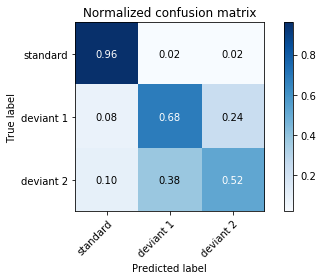

In [153]:
# Plot normalized confusion matrix
plot_confusion_matrix(y_test_123, y_pred_123, classes=['standard', 'deviant 1', 'deviant 2'], normalize=True,
                      title='Normalized confusion matrix')

plt.savefig('confusion_matrix123_training123.pdf')